# Time Series Analysis of Online Retail KPIs

This notebook analyzes daily business KPIs derived from transactional data,
focusing on trend, seasonality, and anomaly detection.

Key metrics:
- Net Revenue
- Non-cancel Orders
- Active Customers (Known IDs only)

## 1. Data Loading

We use the validated daily KPI table generated in Notebook 02.
All metrics follow consistent KPI definitions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

df = pd.read_csv("data/daily_kpi_validated.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

df.head()

,date,orders,active_customers,gross_revenue,return_revenue,items_sold,rows,net_revenue,gross_sales,return_rate,orders_all,orders_non_cancel,cancel_orders,cancel_share,active_customers_known,unknown_customer_rows,unknown_customer_row_share
0,2010-12-01,143,98,58635.56,-325.23,27007.0,3108,58635.56,58960.79,0.005516,143,137,6.0,0.041958,98,1140,0.366795
1,2010-12-02,167,117,46207.28,-1541.10,31348.0,2109,46207.28,47748.38,0.032275,167,144,23.0,0.137725,117,65,0.030820
2,2010-12-03,108,55,45620.46,-1323.25,16471.0,2202,45620.46,46943.71,0.028188,108,101,7.0,0.064815,55,1085,0.492734
3,2010-12-05,95,76,31383.95,-391.00,16451.0,2725,31383.95,31774.95,0.012305,95,88,7.0,0.073684,76,1,0.000367
4,2010-12-06,133,90,53860.18,-970.28,21951.0,3878,53860.18,54830.46,0.017696,133,115,18.0,0.135338,90,1904,0.490975


## 2. Overall Trend Visualization

We start with raw time series plots to understand the overall behavior.

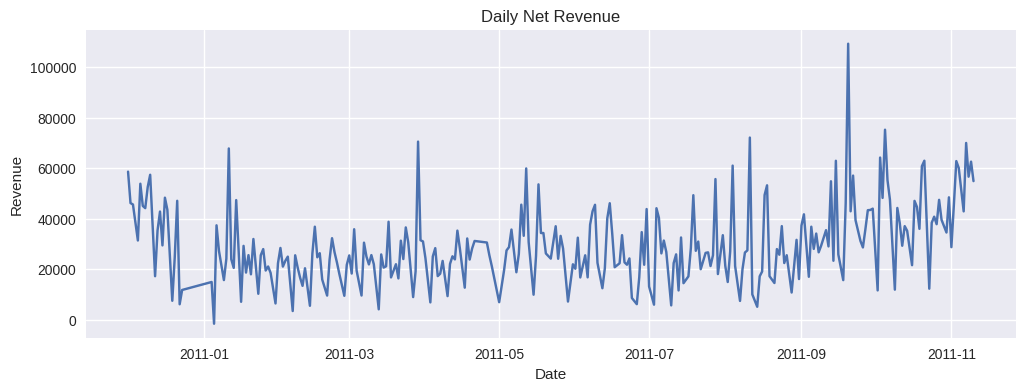

In [3]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["date"], df["net_revenue"])
ax.set_title("Daily Net Revenue")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")
plt.show()

## 3. Trend Smoothing

To reduce day-to-day noise, we apply rolling averages.

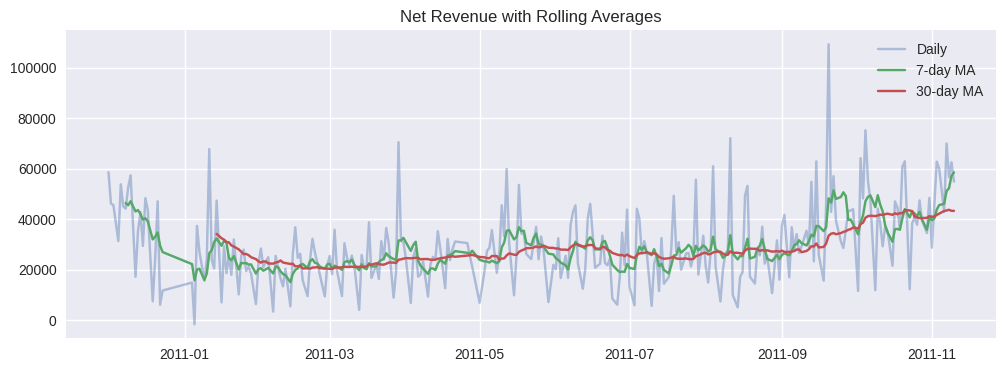

In [4]:
df["net_rev_ma7"] = df["net_revenue"].rolling(7).mean()
df["net_rev_ma30"] = df["net_revenue"].rolling(30).mean()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["date"], df["net_revenue"], alpha=0.4, label="Daily")
ax.plot(df["date"], df["net_rev_ma7"], label="7-day MA")
ax.plot(df["date"], df["net_rev_ma30"], label="30-day MA")
ax.legend()
ax.set_title("Net Revenue with Rolling Averages")
plt.show()

## 4. Weekly Seasonality

We examine whether performance differs systematically by weekday.

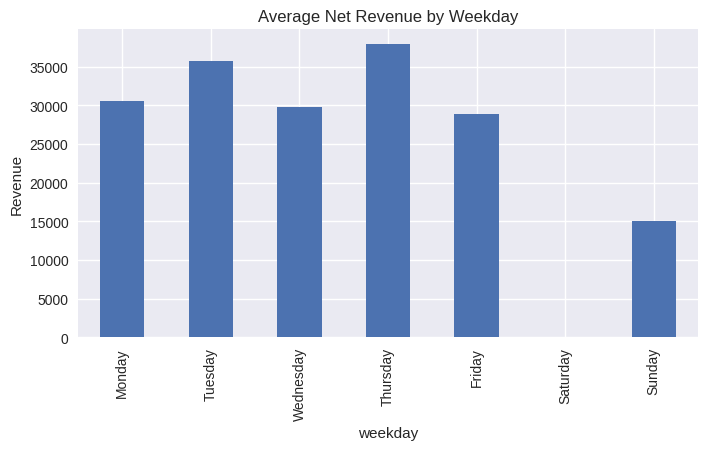

In [5]:
df["weekday"] = df["date"].dt.day_name()

weekday_rev = (
    df.groupby("weekday")["net_revenue"]
      .mean()
      .reindex([
          "Monday","Tuesday","Wednesday",
          "Thursday","Friday","Saturday","Sunday"
      ])
)

weekday_rev.plot(kind="bar", figsize=(8,4), title="Average Net Revenue by Weekday")
plt.ylabel("Revenue")
plt.show()

## 5. Monthly Seasonality
We examine whether performance differs systematically by month.

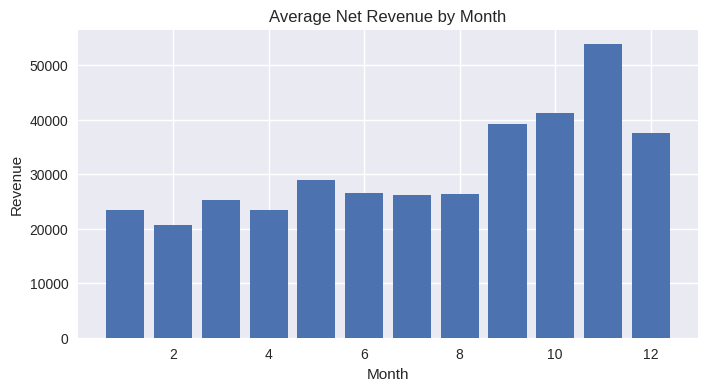

In [8]:
df["month"] = df["date"].dt.month
monthly_avg = df.groupby("month")["net_revenue"].mean()

plt.figure(figsize=(8,4))
plt.bar(monthly_avg.index, monthly_avg.values)
plt.title("Average Net Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

## 6. Time Series Decomposition

We decompose the series into trend, seasonal, and residual components.

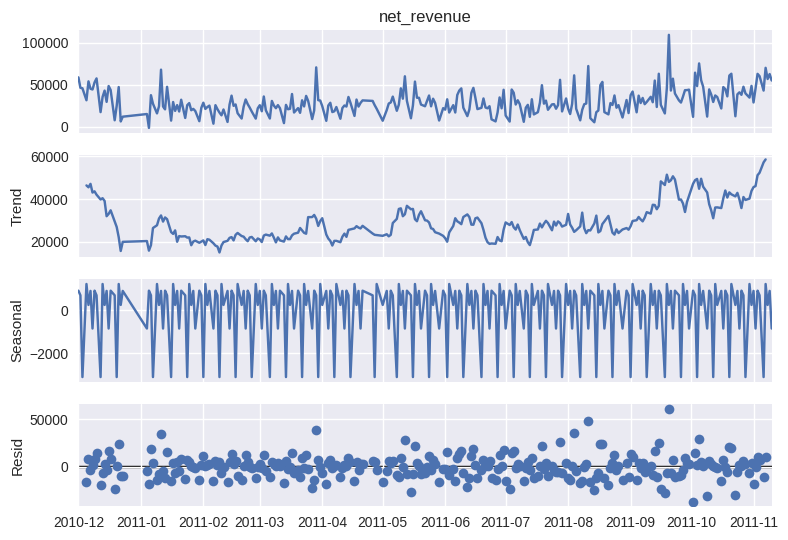

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df.set_index("date")["net_revenue"]

decomp = seasonal_decompose(ts, model="additive", period=7)
decomp.plot()
plt.show()

## 7. Anomaly Detection

We flag days with unusually high or low net revenue.

In [7]:
df["rev_z"] = (df["net_revenue"] - df["net_revenue"].mean()) / df["net_revenue"].std()
df["is_anomaly"] = df["rev_z"].abs() > 3

df[df["is_anomaly"]][["date", "net_revenue", "rev_z"]]

,date,net_revenue,rev_z
235,2011-09-20,109286.21,5.147138


## 8. Key Insights

- Net revenue shows a stable long-term trend with strong weekly seasonality.
- A small number of extreme days account for most volatility.
- These anomalies align with days of high return or cancellation activity.
- Rolling averages provide a more reliable signal for performance monitoring.